In [1]:
import gurobipy as gp
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import re
import time

%matplotlib inline

from markowitz import Markowitz

In [2]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

### Leitura e pré-processamento dos dados de entrada:

In [27]:
df = pd.read_excel('seriehistorica10anos.xlsx')
df.fillna(method='ffill',inplace=True)
df.rename(columns={df.columns[0]: 'datas'},
          inplace=True, errors='raise')

df['datas'] = pd.to_datetime(df['datas'])
df.set_index('datas', inplace = True)

### PARA DROPAR AS ENTRADAS NULAS:
#df = df[(df != 0).all(1)]

### PARA INTERPOLAR AS ENTRADAS NULAS:
df = df.replace(0, pd.NA).interpolate()

pf = pd.read_excel('perfilfundos.xlsx', usecols = ['CNPJ', 'APLICACAO_MINIMA', 'CATEGORIA', 'SUBCATEGORIA'])
#pf['CNPJ'] = pf['CNPJ'].apply(lambda x: re.sub('\W+', '', x))
#pf['CNPJ'] = pf['CNPJ'].apply(lambda x: re.sub('\D+', '', x))
pf['CNPJ'] = pf['CNPJ'].str.replace('[./-]', '', regex=True)
#pf['APLICACAO_MINIMA'] = pd.to_numeric(pf['APLICACAO_MINIMA'].apply(lambda x : re.sub('\D+', '', x)), errors='coerce')
pf['APLICACAO_MINIMA'] = pf['APLICACAO_MINIMA'].str.replace('-', '0').str.replace('R\$ ','').str.replace('.', '').astype(float)
pf.fillna(0, inplace=True)
pf.set_index('CNPJ',inplace=True)
pf_ordered = pf.sort_values(by ='CATEGORIA')
pf_ordered.drop(index=(list(set(pf.index)-set(df.columns))),inplace=True)

cnpj = list(pf_ordered.index)
    
df = df[cnpj]
categorias = list(pf_ordered['CATEGORIA'].unique())
limites = [0]
a = 0
for c in categorias:
    a += len(pf_ordered[pf_ordered['CATEGORIA'] == c])
    limites.append(a)

minFundos = np.array(pf_ordered['APLICACAO_MINIMA'])

n = len(minFundos)

In [26]:
pf

,APLICACAO_MINIMA,CATEGORIA,SUBCATEGORIA
CNPJ,,,
00601692000123,300000.0,Ações,Ações Livre
01608399000150,50000.0,Ações,Ações Livre
00947958000194,50000.0,Multimercados,Multimercados Macro
01430938000104,5000.0,Cambial,Cambial
02539921000152,5000.0,Renda Fixa,Renda Fixa Duração Baixa Grau de Investimento
...,...,...,...
40063500000197,250000.0,Multimercados,Multimercados Investimento no Exterior
40063524000146,10000.0,Multimercados,Multimercados Livre
40063286000179,10000.0,Multimercados,Multimercados Livre


In [33]:
#for col in df:
#    print(df[col] [df[col] <= 0.0001])

In [34]:
#df['11182072000113']['2019-02']

In [35]:
#df['11182072000113']['2019-02'].replace(0, pd.NA).interpolate()

#fig = plt.figure() 
#plt.figure(figsize=(16,12))
#plt.plot(df['11182072000113']['2019-02'].replace(0, pd.NA).interpolate())
#plt.plot(df['11182072000113']['2019-02'])
#plt.ylim((4.5,5.5))
#plt.grid()
#plt.show()


In [4]:
datas = list(df.index.astype(str))
aux = [i[0:4] for i in datas]
anos = pd.Series(aux).unique().tolist()

limites_anos = [0]

a = 0

for c in anos:
    a += aux.count(c)
    limites_anos.append(a)

print(anos)

['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [5]:
limites_anos


[0, 82, 333, 586, 839, 1089, 1340, 1589, 1839, 2092, 2348, 2522]

### Construção de DF_anos e DF_meses (Não utilizados na atual implementação)

In [6]:
DF_anos = dict()

for k in anos:
    DF_anos[k] = df.loc[k].copy()

In [7]:
DF_meses = dict()

for j in anos:
    for k in range(1, 13):
        try:
            DF_meses[j, str(k).zfill(2)] = df.loc[j + '-' + str(k)].copy()
        except:
            pass
        
DF_meses.keys()

dict_keys([('2011', '09'), ('2011', '10'), ('2011', '11'), ('2011', '12'), ('2012', '01'), ('2012', '02'), ('2012', '03'), ('2012', '04'), ('2012', '05'), ('2012', '06'), ('2012', '07'), ('2012', '08'), ('2012', '09'), ('2012', '10'), ('2012', '11'), ('2012', '12'), ('2013', '01'), ('2013', '02'), ('2013', '03'), ('2013', '04'), ('2013', '05'), ('2013', '06'), ('2013', '07'), ('2013', '08'), ('2013', '09'), ('2013', '10'), ('2013', '11'), ('2013', '12'), ('2014', '01'), ('2014', '02'), ('2014', '03'), ('2014', '04'), ('2014', '05'), ('2014', '06'), ('2014', '07'), ('2014', '08'), ('2014', '09'), ('2014', '10'), ('2014', '11'), ('2014', '12'), ('2015', '01'), ('2015', '02'), ('2015', '03'), ('2015', '04'), ('2015', '05'), ('2015', '06'), ('2015', '07'), ('2015', '08'), ('2015', '09'), ('2015', '10'), ('2015', '11'), ('2015', '12'), ('2016', '01'), ('2016', '02'), ('2016', '03'), ('2016', '04'), ('2016', '05'), ('2016', '06'), ('2016', '07'), ('2016', '08'), ('2016', '09'), ('2016', '10'

### Parâmetros de entrada do modelo:

In [164]:
minRetorno = 0.1
C = 100_000

# CONSERVADOR:
#P_categorias = [0.00, 0.00, 0.00, 1.00]
# MODERADO:
P_categorias = [0.25, 0.00, 0.35, 0.50]
# ARROJADO:
#P_categorias = [0.50, 0.10, 0.35, 0.35]

#P_categorias = [0.25, 0.15, 0.25, 0.35]

K_min = 3
K_max = 10
P_min = 0.05
P_max = 0.3
l = 1
log = 0

## Loop Principal versão 2 - Treinamento + Teste:

In [165]:
tam_treinamento = 252
tam_teste = 126
inicio_treinamento = 0
final_treinamento = inicio_treinamento + tam_treinamento
inicio_teste = final_treinamento + 1
final_teste = inicio_teste + tam_teste

DF_retorno_completo = df.pct_change().dropna()

matriz_pesos = DF_retorno_completo.copy()
matriz_pesos = matriz_pesos * 0

hist = dict()

while(final_teste <= DF_retorno_completo.shape[0]):
    minRetorno = 0
    a_retorno = []
    a_risco = []
    a_sharpe = []

    RES = dict()
    k = 0
    
    DF_retorno_treinamento = DF_retorno_completo.iloc[inicio_treinamento:final_treinamento]
   
    sigma = (DF_retorno_treinamento.cov() * 252).to_numpy()
    media = (DF_retorno_treinamento + 1).apply(geo_mean)**252-1
    
    modelo = Markowitz(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites,
    n, minFundos, sigma, media, cnpj)
    
    tempo_init = time.time()
    carteiras, idx_max_sharpe = modelo.solve_fronteira(0.0, 0.7, 0.02)
    Carteira = carteiras[idx_max_sharpe]
    
    #Carteira = modelo.solve()
    print('Tempo total:', time.time() - tempo_init, 's')

    Carteira.exibir(C)

    hist[str(inicio_treinamento), str(final_treinamento)] = Carteira
    print('Resultado referente a slice: ', inicio_treinamento, '-', final_treinamento)
    print('\n')
    print('###############################################')
    print('\n')

    for idx, cnpj_loop in enumerate(Carteira.descricao):
        matriz_pesos[cnpj_loop][inicio_teste:final_teste] = Carteira.porcentagem[idx]
    
    inicio_treinamento += tam_teste
    final_treinamento += tam_teste
    
    inicio_teste += tam_teste
    final_teste += tam_teste

Nenhuma solucao encontrada!
Tempo total: 22.27427387237549 s
Retorno esperado --> 16.0%
Risco estimado --> 1.4%
Fundo 5 (12287682000144) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 25 (10237480000162) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 52 (12004203000135) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 68 (13001211000190) --> 19.52%; R$ 19516.76 --> R$ 5000.0
Fundo 85 (06041290000106) --> 10.48%; R$ 10483.24 --> R$ 1000.0
Fundo 125 (12120451000141) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 128 (09814233000100) --> 5.0%; R$ 5000.0 --> R$ 3000.0
Fundo 130 (10326625000100) --> 10.0%; R$ 10000.0 --> R$ 1000.0
Fundo 149 (10783480000168) --> 30.0%; R$ 30000.0 --> R$ 100.0
Fundo 150 (13554383000191) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Resultado referente a slice:  0 - 252


###############################################


Nenhuma solucao encontrada!
Tempo total: 24.251387119293213 s
Retorno esperado --> 22.0%
Risco estimado --> 2.4%
Fundo 20 (09401978000130) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 52 (

Nenhuma solucao encontrada!
Tempo total: 6.722384214401245 s
Retorno esperado --> 10.0%
Risco estimado --> 1.76%
Fundo 50 (12082452000149) --> 20.0%; R$ 20000.0 --> R$ 20000.0
Fundo 62 (09601190000177) --> 5.0%; R$ 5000.0 --> R$ 0.0
Fundo 64 (13503226000157) --> 10.85%; R$ 10849.79 --> R$ 5000.0
Fundo 115 (09620860000100) --> 11.31%; R$ 11307.19 --> R$ 1000.0
Fundo 118 (09586692000176) --> 7.84%; R$ 7843.02 --> R$ 1000.0
Fundo 132 (09720734000110) --> 15.0%; R$ 15000.0 --> R$ 1000.0
Fundo 151 (11447124000136) --> 30.0%; R$ 30000.0 --> R$ 1000.0
Resultado referente a slice:  1512 - 1764


###############################################


Nenhuma solucao encontrada!
Tempo total: 6.809389591217041 s
Retorno esperado --> 14.0%
Risco estimado --> 3.01%
Fundo 26 (10320151000180) --> 10.0%; R$ 10000.0 --> R$ 1000.0
Fundo 29 (10382858000111) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 62 (09601190000177) --> 6.54%; R$ 6542.32 --> R$ 0.0
Fundo 64 (13503226000157) --> 14.83%; R$ 14829.19 --> R$ 5000

In [121]:
(retorno_perc_carteira[0:126] + 1).prod()
(retorno_perc_carteira[252:252+126] + 1).prod()**2


1.1004633912230686

In [84]:
#for init, fim in hist.keys():
#    print(fim)

2012-09-04    1.000000
2012-09-05    0.999685
2012-09-06    0.999471
2012-09-10    0.999345
2012-09-11    0.998341
                ...   
2021-08-30    2.376050
2021-08-31    2.370273
2021-09-01    2.374059
2021-09-02    2.367108
2021-09-03    2.366379
Name: Retorno Acumulado, Length: 2269, dtype: float64

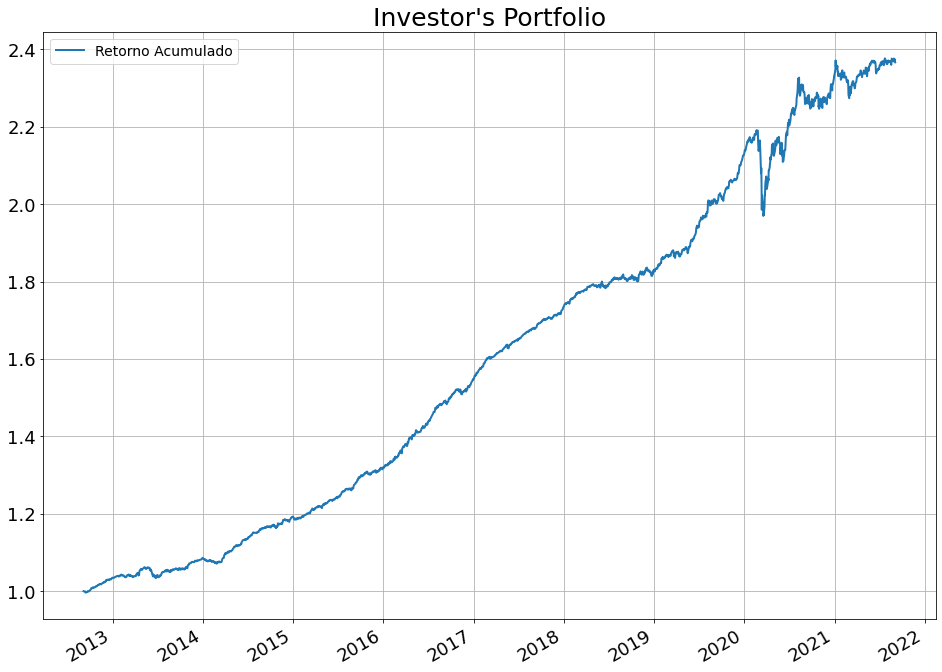

In [166]:
#plt.style.use('ggplot')
#plt.style.use('classic')
#plt.style.use('fast')

#plt.style.use('grayscale')
#plt.style.use('dark_background')

#plt.style.available

retorno_perc_carteira = (matriz_pesos * DF_retorno_completo).sum(axis=1)[tam_treinamento:]

retorno_acum_carteira = (retorno_perc_carteira + 1).cumprod()
retorno_acum_carteira.name = 'Retorno Acumulado'
retorno_acum_carteira.rename_axis(None, inplace=True)
fig = retorno_acum_carteira.plot(figsize = (16,12), grid=True, fontsize = 18, linewidth=2.0)
plt.legend(loc='upper left', fontsize = 14)
plt.title('Investor\'s Portfolio', fontdict = {'fontsize' : 25})
retorno_acum_carteira

#fig.get_figure().savefig('Carteira_Conservador.pdf')

#retorno_acum_carteira.to_csv('Retorno_Conservador10.csv')

#retorno_acum_carteira_arrojado = retorno_acum_carteira.copy()


In [168]:
print(hist.keys())
print()

resultados = list()
    
for idx_loop, periodo in enumerate(hist.keys()):
    init, fim = periodo
    resultados.append([round(hist[init, fim].Retorno * 100, 2), round( (((retorno_perc_carteira[int(init):int(fim) - 126] + 1).prod()**2) - 1) * 100, 2)])
#    print('Retorno treinamento no periodo {}-{}:'.format(init, fim), resultados[idx_loop][0], '%')
#    print('Retorno teste no dia {}:             '.format(int(fim)-126), resultados[idx_loop][1], '%')
#    print()

resultados = pd.DataFrame(resultados, columns = ['Exp.', 'Real'])
resultados = resultados.applymap(lambda x: str(x) + '%')

resultados

#resultados.to_csv('RES_MODERADO_10.csv')
#resultados.to_excel('RES_CONSERVADOR_10.xlsx')

dict_keys([('0', '252'), ('126', '378'), ('252', '504'), ('378', '630'), ('504', '756'), ('630', '882'), ('756', '1008'), ('882', '1134'), ('1008', '1260'), ('1134', '1386'), ('1260', '1512'), ('1386', '1638'), ('1512', '1764'), ('1638', '1890'), ('1764', '2016'), ('1890', '2142'), ('2016', '2268'), ('2142', '2394')])



,Exp.,Real
0,16.0%,8.01%
1,22.0%,3.11%
2,12.0%,4.12%
3,10.0%,16.79%
4,12.04%,6.86%
5,18.0%,12.24%
6,18.0%,13.71%
7,14.0%,20.5%
8,20.0%,15.09%
9,18.0%,10.16%


In [169]:
#retorno_acum_carteira[-1]  ** (1./9.5)

#conservador = pd.read_csv('Retorno_Conservador10.csv', index_col=0)
#conservador = conservador.iloc[:, 0]
#conservador.index = pd.to_datetime(conservador.index)
#conservador

# ----------- MATERIAIS MAIS ANTIGOS -----------

### Seleção do Período do Estudo - O período final é onde a janela TERMINA, e não o início do período final:

In [ ]:
ano_inicial = 2012
ano_final = 2017
mes_inicial = 1
mes_final = 1
intervalo_mensal = 6

In [ ]:
mes_atual = mes_inicial
anos_escolhidos = [str(j) for j in range(ano_inicial, ano_final + 1)]
datas_escolhidas = list()
for i in anos_escolhidos:
    while(True):
        if( (int(i) == ano_final) and (mes_atual > mes_final)):
            break
        datas_escolhidas.append( (i, str(mes_atual).zfill(2)) )
        if (mes_atual + intervalo_mensal) <= 12:
            mes_atual += intervalo_mensal
        else:
            mes_atual = (mes_atual + intervalo_mensal) % 12
            break

datas_escolhidas

## LOOP Principal versão 1 - sem a parte de teste - Resolvendo os modelos em cada período da janela rolante:

In [25]:
hist = dict()

pf = pd.read_excel('perfilfundos.xlsx', usecols = ['CNPJ', 'APLICACAO_MINIMA', 'CATEGORIA', 'SUBCATEGORIA'])
pf['CNPJ'] = pf['CNPJ'].apply(lambda x: re.sub('\W+', '', x))
pf['APLICACAO_MINIMA'] = pd.to_numeric(pf['APLICACAO_MINIMA'].apply(lambda x : re.sub('\D+', '', x)), errors='coerce')
pf.fillna(0, inplace=True)
pf.set_index('CNPJ',inplace=True)
pf_ordered = pf.sort_values(by ='CATEGORIA')
pf_ordered.drop(index=(list(set(pf.index)-set(df.columns))),inplace=True)

cnpj = list(pf_ordered.index)
    
df = df[cnpj]
categorias = list(pf_ordered['CATEGORIA'].unique())
limites = [0]
a = 0
for c in categorias:
    a += len(pf_ordered[pf_ordered['CATEGORIA'] == c])
    limites.append(a)

minFundos = np.array(pf_ordered['APLICACAO_MINIMA'])

n = len(minFundos)

    
DF_iteracao = None

if(len(datas_escolhidas) <= 1):
    print('--- CASO ANTERIOR ---')
else:
    for idx in range(len(datas_escolhidas) - 1):
        DF_iteracao = df.loc[datas_escolhidas[idx][0]+'-'+datas_escolhidas[idx][1] : 
                             datas_escolhidas[idx+1][0]+'-'+datas_escolhidas[idx+1][1]]
        
        df_retorno = DF_iteracao.pct_change().dropna()
        sigma = (df_retorno.cov()*252).to_numpy()
        media = (df_retorno+1).apply(geo_mean)**252-1

        tempo_init = time.time()
        modelo = Markowitz(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites,
        n, minFundos, sigma, media, cnpj)
        Carteira = modelo.solve()
        print('Tempo total:', time.time() - tempo_init, 's')

        Carteira.exibir(C)

        hist[datas_escolhidas[idx][0], datas_escolhidas[idx][1]] = Carteira
        print('Resultado referente ao periodo: ', datas_escolhidas[idx][0] + '-' + datas_escolhidas[idx][1])
        print('\n')
        print('###############################################')
        print('\n')
        
        DF_iteracao = None

NameError: name 'datas_escolhidas' is not defined

## Plot "validação" para um fundo:

    -) Em azul: a série temporal usada para a previsão dos retornos;
    -) Em vermelho: a série temporal dos seis próximos meses (período do investimento);
    -) Em laranja: a série temporal do mês após o final do investimento.

In [ ]:
hist['2012', '01'].exibir(C)

fundo = '13001211000190'
fundo_ruim = '12120451000141'

df['2012-01':'2012-07-03'][fundo].plot(style = '-b', figsize = (12, 8))
df['2012-07':'2013-01-03'][fundo].plot(style = '--r')
fig = df['2013-01'][fundo].plot(style = '--', color='orange', grid=True)

#fig.get_figure().savefig('Figura1.pdf')

In [132]:
carteiras[0].descricao

hist['0', '252'].descricao

['09543255000175',
 '04899128000190',
 '10783480000168',
 '11447124000136',
 '07381653000107']

# Previsão X Resultado - Ano de 2012:

`Observação:` Os dados foram convertidos em **escores Z** para o plot poder ser colocado em escala!

### Saída do modelo - Fundos escolhidos tomando por base o período 2012/01 ~ 2012/06:

In [158]:
import cufflinks as cf
from plotly.offline import plot, iplot

#lista_cnpj = ['29177024000100', '08968733000126', '20077065000142', '33736873000116',
#'31964074000171', '19959703000170', '21732619000160', '26664935000166', '30934757000113']

cf.go_offline()

dados_periodo = df.iloc[2142:2394]

cnpj_periodo = hist['2142', '2394'].descricao

series_temp = dados_periodo[cnpj_periodo]

series_temp = (series_temp - series_temp.mean())/series_temp.std()

series_temp.iplot()


In [155]:
hist.keys()

dict_keys([('0', '252'), ('126', '378'), ('252', '504'), ('378', '630'), ('504', '756'), ('630', '882'), ('756', '1008'), ('882', '1134'), ('1008', '1260'), ('1134', '1386'), ('1260', '1512'), ('1386', '1638'), ('1512', '1764'), ('1638', '1890'), ('1764', '2016'), ('1890', '2142'), ('2016', '2268'), ('2142', '2394')])

### Seis próximos meses - Resultado da aplicação selecionada

In [ ]:
import cufflinks as cf
from plotly.offline import plot, iplot

cf.go_offline()

dados_periodo = df.loc['2012-07':'2013-01']

cnpj_periodo = hist['2012', '01'].descricao

series_temp = dados_periodo[cnpj_periodo]

series_temp = (series_temp - series_temp.mean())/series_temp.std()

series_temp.iplot()
